# Dev info
- Feature: Use Numpy interpolation to fill the gaps
- Runs on: ReSurfEMG V1.1.1
- Methods: resurfemg.preprocessing.ecg_removal.gating

- Explanation: Gating method used a custom implementation for interpolation to
fill the gate windows. Using dedicated Numpy methods might speed-up to process
and make the function more transparent.

# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import time
import numpy as np
import pandas as pd
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt


# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.converter_functions import load_file

from resurfemg.preprocessing import filtering as filt
from resurfemg.preprocessing import ecg_removal as ecg_rm

config = Config()

%matplotlib widget

## 2. Load sEMG test data

## Synthetic data

In [2]:
# For the test data:
base_path = config.get_directory('test_data')

files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='*',
    extension_regex='Poly5',
    folder_levels=None,
    verbose=False
)
button_list = ipy_widgets.file_select(
    files=files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('emg_data_synth_pocc.Poly5', 'emg_data_synth_qui…

## Patient data

In [3]:
# # Identify all recordings available for the selected patient/measurement_date

# # First find the patients
# config = Config()
# base_path = config.get_directory('root_patient_data')
# patient_paths = file_discovery.find_folders(
#     base_path,
#     folder_levels=['patient'])
# patient = list(patient_paths['patient'].values)[0]

# # Then find the files for the selected patients:
# folder_levels = ['date', 'measurement']
# patient_path = os.path.join(base_path, patient)

# emg_files = file_discovery.find_files(
#     base_path=patient_path,
#     file_name_regex='EMG_recording',
#     extension_regex='poly5',
#     folder_levels=folder_levels)

# folder_levels = ['date', 'measurement']
# vent_files = file_discovery.find_files(
#     base_path=patient_path,
#     file_name_regex='Draeger_recording',
#     extension_regex='poly5',
#     folder_levels=folder_levels)

# button_list = ipy_widgets.file_select(
#     emg_files,
#     folder_levels=folder_levels,
#     default_value_select=None,
#     default_idx_select=[1, 6, None])
# emg_file_chosen = os.path.join(
#     patient_path, *[btn.value for btn in button_list], 'EMG_recording.Poly5')
# vent_file_chosen = os.path.join(
#     patient_path, *[btn.value for btn in button_list], 'Draeger_recording.Poly5')

# print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

In [4]:
# Load the EMG from the selected folders (synthetic data):
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list])

# # Load the EMG from the selected folders:
# emg_file_chosen = os.path.join(patient_path, *[btn.value for btn in button_list])

y_emg_raw, _, metadata_emg = load_file(emg_file_chosen)
fs_emg = metadata_emg['fs']

t_emg = [i/fs_emg for i in range(len(y_emg_raw[0, :]))]

# Load the Ventilator from the selected folders:
# y_vent, _, metadata_vent = load_file(vent_file_chosen)
# fs_vent = metadata_vent['fs']
# 
# y_vent = y_vent
# t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]


Detected .poly5
Loading .Poly5 ...
Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\emg_data_synth_pocc.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Loaded .Poly5, extracting data ...
Loading data completed
Selected channels: [0, 1]


# 3. Pre-process the data

In [5]:
# Gating for comparison
y_emg_filt = filt.emg_bandpass_butter(
    y_emg_raw,
    fs_emg=fs_emg,
    high_pass=20,
    low_pass=500,
    order=4,
)


In [6]:
# Detect ECG peaks
ecg_peaks_idxs = ecg_rm.detect_ecg_peaks(
    ecg_raw=y_emg_raw[0, :],
    fs=fs_emg)

# 4. Define new and original methods

In [7]:
# Gating function in ReSurfEMG v1.1.0
import copy
import numpy as np
import scipy
import pywt
import pandas as pd

from resurfemg.preprocessing import envelope as evl
import resurfemg.preprocessing.filtering as filt

def gating_v1_1_0(
    emg_raw,
    peak_idxs,
    gate_width=205,
    method=1,
):
    """
    Eliminate peaks (e.g. QRS) from emg_raw using gates
    of width gate_width. The gate either filled by zeros or interpolation.
    The filling method for the gate is encoded as follows:
    0: Filled with zeros
    1: Interpolation samples before and after
    2: Fill with average of prior segment if exists
    otherwise fill with post segment
    3: Fill with running average of RMS (default)
    ---------------------------------------------------------------------------
    :param emg_raw: Signal to process
    :type emg_raw: ~numpy.ndarray
    :param peak_idxs: list of individual peak index places to be gated
    :type peak_idxs: ~list
    :param gate_width: width of the gate
    :type gate_width: int
    :param method: filling method of gate
    :type method: int

    :returns emg_raw_gated: the gated result
    :rtype emg_raw_gated: numpy.ndarray
    """
    emg_raw_gated = copy.deepcopy(emg_raw)
    max_sample = emg_raw_gated.shape[0]
    half_gate_width = gate_width // 2
    if method == 0:
        # Method 0: Fill with zeros
        # TODO: can rewrite with slices from numpy irange to be more efficient
        gate_samples = []
        for _, peak in enumerate(peak_idxs):
            for k in range(
                max(0, peak - half_gate_width),
                min(max_sample, peak + half_gate_width),
            ):
                gate_samples.append(k)

        emg_raw_gated[gate_samples] = 0
    elif method == 1:
        # Method 1: Fill with interpolation pre- and post gate sample
        # TODO: rewrite with numpy interpolation for efficiency
        for _, peak in enumerate(peak_idxs):
            pre_ave_emg = emg_raw[peak-half_gate_width-1]

            if (peak + half_gate_width + 1) < emg_raw_gated.shape[0]:
                post_ave_emg = emg_raw[peak+half_gate_width+1]
            else:
                post_ave_emg = 0

            k_start = max(0, peak-half_gate_width)
            k_end = min(
                peak+half_gate_width, emg_raw_gated.shape[0]
            )
            for k in range(k_start, k_end):
                frac = (k - peak + half_gate_width)/gate_width
                loup = (1 - frac) * pre_ave_emg + frac * post_ave_emg
                emg_raw_gated[k] = loup

    elif method == 2:
        # Method 2: Fill with window length mean over prior section
        # ..._____|_______|_______|XXXXXXX|XXXXXXX|_____...
        #         ^               ^- gate start   ^- gate end
        #         - peak - half_gate_width * 3 (replacer)

        for _, peak in enumerate(peak_idxs):
            start = peak - half_gate_width * 3
            if start < 0:
                start = peak + half_gate_width
            end = start + gate_width
            pre_ave_emg = np.nanmean(emg_raw[start:end])

            k_start = max(0, peak - half_gate_width)
            k_end = min(peak + half_gate_width, emg_raw_gated.shape[0])
            for k in range(k_start, k_end):
                emg_raw_gated[k] = pre_ave_emg

    elif method == 3:
        # Method 3: Fill with moving average over RMS
        gate_samples = []
        for _, peak in enumerate(peak_idxs):
            for k in range(
                max([0, int(peak-gate_width/2)]),
                min([max_sample, int(peak+gate_width/2)])
            ):
                gate_samples.append(k)
        emg_raw_gated_base = copy.deepcopy(emg_raw_gated)
        emg_raw_gated_base[gate_samples] = np.nan
        emg_raw_gated_rms = evl.full_rolling_rms(
            emg_raw_gated_base,
            gate_width,)

        interpolate_samples = list()
        r_idx = 0
        for _, peak in enumerate(peak_idxs):
            k_start = max([0, int(peak-gate_width/2)])
            k_end = min([int(peak+gate_width/2), max_sample])

            for k in range(k_start, k_end):
                leftf = max([0, int(k-1.5*gate_width)])
                rightf = min([int(k+1.5*gate_width), max_sample])
                if any(np.logical_not(np.isnan(
                        emg_raw_gated_rms[leftf:rightf]))):
                    emg_raw_gated[k] = np.nanmean(
                        emg_raw_gated_rms[leftf:rightf]
                    )
                else:
                    interpolate_samples.append(k)
        if len(interpolate_samples) > 0:
            print("Interpolation needed for", len(interpolate_samples), "samples")
            interpolate_samples = np.array(interpolate_samples)
            if 0 in interpolate_samples:
                emg_raw_gated[0] = 0

            if len(emg_raw_gated)-1 in interpolate_samples:
                emg_raw_gated[-1] = 0

            x_samp = np.array([x_i for x_i in range(len(emg_raw_gated))])
            other_samples = x_samp[~np.isin(x_samp, interpolate_samples)]
            emg_raw_gated_interp = np.interp(
                x_samp[interpolate_samples],
                x_samp[other_samples],
                emg_raw_gated[other_samples])
            emg_raw_gated[interpolate_samples] = emg_raw_gated_interp

    return emg_raw_gated

In [20]:
def gating_new(
    emg_raw,
    peak_idxs,
    gate_width=205,
    method=1,
    **kwargs
):
    """
    Eliminate peaks (e.g. QRS) from emg_raw using gates
    of width gate_width. The gate either filled by zeros or interpolation.
    The filling method for the gate is encoded as follows:
    0: Filled with zeros
    1: Interpolation samples before and after
    2: Fill with average of prior segment if exists
    otherwise fill with post segment
    3: Fill with running average of RMS (default)
    ---------------------------------------------------------------------------
    :param emg_raw: Signal to process
    :type emg_raw: ~numpy.ndarray
    :param peak_idxs: list of individual peak index places to be gated
    :type peak_idxs: ~list
    :param gate_width: width of the gate
    :type gate_width: int
    :param method: filling method of gate
    :type method: int

    :returns emg_raw_gated: the gated result
    :rtype emg_raw_gated: numpy.ndarray
    """
    emg_raw_gated = copy.deepcopy(emg_raw)
    max_sample = emg_raw_gated.shape[0]
    half_gate_width = gate_width // 2
    if method == 0:
        # Method 0: Fill with zeros
        # Vectorized construction of gate sample indices
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size == 0:
            gate_samples = np.array([], dtype=int)
        else:
            starts = np.maximum(0, peaks - half_gate_width)
            ends = np.minimum(max_sample, peaks + half_gate_width)
            # build ranges per peak and concat, then unique to avoid duplicates
            gate_samples = np.concatenate(
                [np.arange(s, e) for s, e in zip(starts, ends)])
            gate_samples = np.unique(gate_samples).astype(int)

        emg_raw_gated[gate_samples] = 0
    elif method == 1:
        # Method 1: Fill with interpolation pre- and post gate sample
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size > 0:
            max_sample = emg_raw_gated.shape[0]
            for peak in peaks:
                pre_idx = peak - half_gate_width - 1
                pre_val = emg_raw[pre_idx] if (
                    pre_idx >= 0 and pre_idx < max_sample) else 0

                post_idx = peak + half_gate_width + 1
                post_val = emg_raw[post_idx] if (
                    post_idx >= 0 and post_idx < max_sample) else 0

                k_start = max(0, peak - half_gate_width)
                k_end = min(peak + half_gate_width, max_sample)
                if k_start >= k_end:
                    continue

                ks = np.arange(k_start, k_end)
                frac = (ks - peak + half_gate_width) / float(gate_width)
                emg_raw_gated[ks] = (1.0 - frac) * pre_val + frac * post_val

    elif method == 2:
        # Method 2: Fill with window length mean over prior section
        # ..._____|_______|_______|XXXXXXX|XXXXXXX|_____...
        #         ^               ^- gate start   ^- gate end
        #         - peak - half_gate_width * 3 (replacer)

        for _, peak in enumerate(peak_idxs):
            start = peak - half_gate_width * 3
            if start < 0:
                start = peak + half_gate_width
            end = start + gate_width
            pre_ave_emg = np.nanmean(emg_raw[start:end])

            k_start = max(0, peak - half_gate_width)
            k_end = min(peak + half_gate_width, emg_raw_gated.shape[0])
            for k in range(k_start, k_end):
                emg_raw_gated[k] = pre_ave_emg

    elif method == 3:
        # Method 3: Fill with moving average over RMS
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size > 0:
            # Build boolean mask of gate samples
            gate_mask = np.zeros(max_sample, dtype=bool)
            half_w = gate_width / 2
            starts = np.maximum(0, (peaks - half_w).astype(int))
            ends = np.minimum(max_sample, (peaks + half_w).astype(int))
            for s, e in zip(starts, ends):
                if s < e:
                    gate_mask[s:e] = True            

            # Compute RMS with gated samples as NaN
            emg_raw_gated_base = emg_raw_gated.copy()
            emg_raw_gated_base[gate_mask] = np.nan
            emg_raw_gated_rms = evl.full_rolling_rms(
                emg_raw_gated_base, gate_width)

            # Compute local mean of the RMS over a window of ~3*gate_widths
            w = max(1, 2 * int(1.5 * gate_width) + 1)
            if gate_width % 2 == 0:
                closed = "neither"
            else:
                closed = "left"
            local_mean = pd.Series(emg_raw_gated_rms).rolling(
                window=w,
                min_periods=1,
                center=True,
                closed=closed).mean().values

            # Assign local_mean where available within gates
            mask_available = gate_mask & (~np.isnan(local_mean))
            emg_raw_gated[mask_available] = local_mean[mask_available]

            # Remaining gate samples to interpolate
            interp_mask = gate_mask & np.isnan(local_mean)
            # # TODO: Interpolation is combined below for methods 3 and 4
            # if np.any(interp_mask):'
            #     interp_idx = np.nonzero(interp_mask)[0]
            #     other_idx = np.nonzero(~interp_mask)[0]

            #     # Boundary handling: Set endpoints to 0 if part of interp_idx
            #     if 0 in interp_idx:
            #         emg_raw_gated[0] = 0.0
            #         interp_mask[0] = False
            #     if (max_sample - 1) in interp_idx:
            #         emg_raw_gated[-1] = 0.0
            #         interp_mask[-1] = False

            #     interp_idx = np.nonzero(interp_mask)[0]
            #     other_idx = np.nonzero(~interp_mask)[0]

            #     if other_idx.size > 0 and interp_idx.size > 0:
            #         # Ensure there are values to interpolate from
            #         emg_raw_gated_interp = np.interp(
            #             interp_idx,
            #             other_idx,
            #             emg_raw_gated[other_idx]
            #         )
            #         emg_raw_gated[interp_idx] = emg_raw_gated_interp
    elif method == 4:
        # Method 4: Fill with quadratic fit to RMS 
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size > 0:
            # Build boolean mask of gate samples
            gate_mask = np.zeros(max_sample, dtype=bool)
            half_w = gate_width / 2
            starts = np.maximum(0, (peaks - half_w).astype(int))
            ends = np.minimum(max_sample, (peaks + half_w).astype(int))
            for s, e in zip(starts, ends):
                if s < e:
                    gate_mask[s:e] = True

            # Compute RMS with gated samples as NaN
            emg_raw_gated_base = emg_raw_gated.copy()
            emg_raw_gated_base[gate_mask] = np.nan
            emg_raw_gated_rms = evl.full_rolling_rms(
                emg_raw_gated_base, gate_width)
            emg_raw_gated[gate_mask] = np.nan

            # Fit a local cubic (or lower-degree if needed) to RMS using
            local_mean = np.full(max_sample, np.nan)
            # identify contiguous gated segments
            gated_idx = np.nonzero(gate_mask)[0]
            if gated_idx.size > 0:
                # find breaks in the gated indices to get segments
                breaks = np.where(np.diff(gated_idx) != 1)[0]
                seg_starts = gated_idx[np.concatenate(([0], breaks + 1))]
                seg_ends = gated_idx[np.concatenate((
                    breaks, [gated_idx.size - 1]))]
                
                poly_width = kwargs.get('poly_width', 5 * gate_width)

                for gs, ge in zip(seg_starts, seg_ends):
                    pre_s = max(0, gs - poly_width // 2)
                    post_e = min(max_sample, ge + 1 + poly_width // 2)

                    # support indices and values from RMS (skip NaNs)
                    idx_pre = np.arange(pre_s, gs)
                    idx_post = np.arange(ge + 1, post_e)
                    support_idx = np.concatenate((idx_pre, idx_post))
                    support_vals = emg_raw_gated_rms[support_idx]
                    valid_mask = ~np.isnan(support_vals)
                    valid_idx = support_idx[valid_mask]
                    valid_vals = support_vals[valid_mask]

                    # fit polynomial to valid RMS support
                    fit_available = valid_idx.size >= 2
                    if fit_available:
                        deg = min(2, valid_idx.size - 1)
                        p_seg = np.polyfit(
                            valid_idx, valid_vals, deg)
                        ks = np.arange(gs, ge + 1)
                        emg_raw_gated[gs:ge + 1] = np.polyval(p_seg, ks)
            interp_mask = gate_mask & np.isnan(emg_raw_gated)
    if method in [3, 4]:
        if np.any(interp_mask):
            interp_idx = np.nonzero(interp_mask)[0]
            other_idx = np.nonzero(~interp_mask)[0]

            # Boundary handling: Set endpoints to 0 if part of interp_idx
            if 0 in interp_idx:
                emg_raw_gated[0] = 0.0
                interp_mask[0] = False
            if (max_sample - 1) in interp_idx:
                emg_raw_gated[-1] = 0.0
                interp_mask[-1] = False

            interp_idx = np.nonzero(interp_mask)[0]
            other_idx = np.nonzero(~interp_mask)[0]

            if other_idx.size > 0 and interp_idx.size > 0:
                # Ensure there are values to interpolate from
                emg_raw_gated_interp = np.interp(
                    interp_idx,
                    other_idx,
                    emg_raw_gated[other_idx]
                )
                emg_raw_gated[interp_idx] = emg_raw_gated_interp
 

    return emg_raw_gated

In [9]:
# Method 1 comparison
print("======================================================================")
print("Method 1 comparison")
print("======================================================================")
method = 1

n_reps = 100
times_v1 = np.zeros(n_reps)
times_new = np.zeros(n_reps)
max_diffs = np.zeros(n_reps)
mean_diffs = np.zeros(n_reps)

for i in range(n_reps):
    tic = time.perf_counter()
    out_v1 = gating_v1_1_0(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=method,
    )
    toc = time.perf_counter()
    times_v1[i] = toc - tic

    tic = time.perf_counter()
    out_new = gating_new(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=method,
    )
    toc = time.perf_counter()
    times_new[i] = toc - tic

    diff = out_v1 - out_new
    max_diffs[i] = np.max(np.abs(diff))
    mean_diffs[i] = np.mean(np.abs(diff))

# Summary statistics
mean_time_v1 = times_v1.mean()
mean_time_new = times_new.mean()
std_time_v1 = times_v1.std()
std_time_new = times_new.std()
mean_improvement_frac = np.mean((times_v1 - times_new) / times_v1)  # fraction
mean_improvement_pct = mean_improvement_frac * 100

print("Original ReSurfEMG v1.1.0 (mean ± std): "
      f"{mean_time_v1:0.6f} ± {std_time_v1:0.6f} s")
print("New method (mean ± std): "
      f"{mean_time_new:0.6f} ± {std_time_new:0.6f} s")
print(f"Average speed improvement: {mean_improvement_pct:0.3f}% (mean over {n_reps} reps)")
print(f"Average time per peak (v1.1.0): {mean_time_v1/len(ecg_peaks_idxs):0.8f} s/peak")
print(f"Average time per peak (new):     {mean_time_new/len(ecg_peaks_idxs):0.8f} s/peak")

# Difference checks
n_zero_exact = np.sum(max_diffs == 0.0)
n_zero_close = np.sum(np.isclose(max_diffs, 0.0, atol=1e-12))
print("---------------------------------------------------------------------")
print(f"Runs with exact zero max-difference: {n_zero_exact}/{n_reps}")
print(f"Runs with max-difference ≈ 0 (tol=1e-12): {n_zero_close}/{n_reps}")
print(f"Max of max-differences across runs: {max_diffs.max():.12e}")
print(f"Mean of max-differences across runs: {max_diffs.mean():.12e}")
print(f"Mean of mean-differences across runs: {mean_diffs.mean():.12e}")
print("======================================================================")


Method 1 comparison
Original ReSurfEMG v1.1.0 (mean ± std): 0.043134 ± 0.006805 s
New method (mean ± std): 0.007436 ± 0.001630 s
Average speed improvement: 82.681% (mean over 100 reps)
Average time per peak (v1.1.0): 0.00015350 s/peak
Average time per peak (new):     0.00002646 s/peak
---------------------------------------------------------------------
Runs with exact zero max-difference: 100/100
Runs with max-difference ≈ 0 (tol=1e-12): 100/100
Max of max-differences across runs: 0.000000000000e+00
Mean of max-differences across runs: 0.000000000000e+00
Mean of mean-differences across runs: 0.000000000000e+00


In [10]:
# Method 2 comparison
print("======================================================================")
print("Method 2 comparison")
print("======================================================================")
method = 2

n_reps = 100
times_v1 = np.zeros(n_reps)
times_new = np.zeros(n_reps)
max_diffs = np.zeros(n_reps)
mean_diffs = np.zeros(n_reps)

for i in range(n_reps):
    tic = time.perf_counter()
    out_v1 = gating_v1_1_0(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=method,
    )
    toc = time.perf_counter()
    times_v1[i] = toc - tic

    tic = time.perf_counter()
    out_new = gating_new(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=method,
    )
    toc = time.perf_counter()
    times_new[i] = toc - tic

    diff = out_v1 - out_new
    max_diffs[i] = np.max(np.abs(diff))
    mean_diffs[i] = np.mean(np.abs(diff))

# Summary statistics
mean_time_v1 = times_v1.mean()
mean_time_new = times_new.mean()
std_time_v1 = times_v1.std()
std_time_new = times_new.std()
mean_improvement_frac = np.mean((times_v1 - times_new) / times_v1)  # fraction
mean_improvement_pct = mean_improvement_frac * 100

print("Original ReSurfEMG v1.1.0 (mean ± std): "
      f"{mean_time_v1:0.6f} ± {std_time_v1:0.6f} s")
print("New method (mean ± std): "
      f"{mean_time_new:0.6f} ± {std_time_new:0.6f} s")
print(f"Average speed improvement: {mean_improvement_pct:0.3f}% (mean over {n_reps} reps)")
print(f"Average time per peak (v1.1.0): {mean_time_v1/len(ecg_peaks_idxs):0.8f} s/peak")
print(f"Average time per peak (new):     {mean_time_new/len(ecg_peaks_idxs):0.8f} s/peak")

# Difference checks
n_zero_exact = np.sum(max_diffs == 0.0)
n_zero_close = np.sum(np.isclose(max_diffs, 0.0, atol=1e-12))
print("---------------------------------------------------------------------")
print(f"Runs with exact zero max-difference: {n_zero_exact}/{n_reps}")
print(f"Runs with max-difference ≈ 0 (tol=1e-12): {n_zero_close}/{n_reps}")
print(f"Max of max-differences across runs: {max_diffs.max():.12e}")
print(f"Mean of max-differences across runs: {max_diffs.mean():.12e}")
print(f"Mean of mean-differences across runs: {mean_diffs.mean():.12e}")
print("======================================================================")


Method 2 comparison
Original ReSurfEMG v1.1.0 (mean ± std): 0.026278 ± 0.009667 s
New method (mean ± std): 0.025894 ± 0.006778 s
Average speed improvement: -2.686% (mean over 100 reps)
Average time per peak (v1.1.0): 0.00009351 s/peak
Average time per peak (new):     0.00009215 s/peak
---------------------------------------------------------------------
Runs with exact zero max-difference: 100/100
Runs with max-difference ≈ 0 (tol=1e-12): 100/100
Max of max-differences across runs: 0.000000000000e+00
Mean of max-differences across runs: 0.000000000000e+00
Mean of mean-differences across runs: 0.000000000000e+00


In [11]:
# Method 3 comparison
window = 205
print("======================================================================")
print("Method 3 comparison")
print("======================================================================")
method = 3

n_reps = 5
times_v1 = np.zeros(n_reps)
times_new = np.zeros(n_reps)
max_diffs = np.zeros(n_reps)
mean_diffs = np.zeros(n_reps)

for i in range(n_reps):
    tic = time.perf_counter()
    out_v1 = gating_v1_1_0(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=method,
        gate_width=window
    )
    toc = time.perf_counter()
    times_v1[i] = toc - tic

    tic = time.perf_counter()
    out_new = gating_new(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=method,
        gate_width=window
    )
    toc = time.perf_counter()
    times_new[i] = toc - tic

    diff = out_v1 - out_new
    max_diffs[i] = np.max(np.abs(diff))
    mean_diffs[i] = np.mean(np.abs(diff))

# Summary statistics
mean_time_v1 = times_v1.mean()
mean_time_new = times_new.mean()
std_time_v1 = times_v1.std()
std_time_new = times_new.std()
mean_improvement_frac = np.mean((times_v1 - times_new) / times_v1)  # fraction
mean_improvement_pct = mean_improvement_frac * 100

print("Original ReSurfEMG v1.1.0 (mean ± std): "
      f"{mean_time_v1:0.6f} ± {std_time_v1:0.6f} s")
print("New method (mean ± std): "
      f"{mean_time_new:0.6f} ± {std_time_new:0.6f} s")
print(f"Average speed improvement: {mean_improvement_pct:0.3f}% (mean over {n_reps} reps)")
print(f"Average time per peak (v1.1.0): {mean_time_v1/len(ecg_peaks_idxs):0.8f} s/peak")
print(f"Average time per peak (new):     {mean_time_new/len(ecg_peaks_idxs):0.8f} s/peak")

# Difference checks
n_zero_exact = np.sum(max_diffs == 0.0)
n_zero_close = np.sum(np.isclose(max_diffs, 0.0, atol=1e-12))
print("---------------------------------------------------------------------")
print(f"Runs with exact zero max-difference: {n_zero_exact}/{n_reps}")
print(f"Runs with max-difference ≈ 0 (tol=1e-12): {n_zero_close}/{n_reps}")
print(f"Max of max-differences across runs: {max_diffs.max():.12e}")
print(f"Mean of max-differences across runs: {max_diffs.mean():.12e}")
print(f"Mean of mean-differences across runs: {mean_diffs.mean():.12e}")
print("======================================================================")


Method 3 comparison
Original ReSurfEMG v1.1.0 (mean ± std): 3.198082 ± 0.887588 s
New method (mean ± std): 0.106740 ± 0.025473 s
Average speed improvement: 96.587% (mean over 5 reps)
Average time per peak (v1.1.0): 0.01138108 s/peak
Average time per peak (new):     0.00037986 s/peak
---------------------------------------------------------------------
Runs with exact zero max-difference: 0/5
Runs with max-difference ≈ 0 (tol=1e-12): 5/5
Max of max-differences across runs: 3.552713678801e-15
Mean of max-differences across runs: 3.552713678801e-15
Mean of mean-differences across runs: 1.426964945016e-17


In [12]:
# Add adjacent peaks
ecg_peaks_idxs_new = np.append(ecg_peaks_idxs, ecg_peaks_idxs[ecg_peaks_idxs > 0][1] - window)
ecg_peaks_idxs_new = np.append(ecg_peaks_idxs_new, ecg_peaks_idxs_new[ecg_peaks_idxs_new > 0][1] + window)
ecg_peaks_idxs_new = np.append(ecg_peaks_idxs_new, ecg_peaks_idxs_new[ecg_peaks_idxs_new > 0][1] + 2 * window)
# ecg_peaks_idxs_new

In [13]:
# Method 3 comparison - adjacent peaks for interpolation
window = 205
print("======================================================================")
print("Method 3 comparison")
print("======================================================================")
method = 3

n_reps = 5
times_v1 = np.zeros(n_reps)
times_new = np.zeros(n_reps)
max_diffs = np.zeros(n_reps)
mean_diffs = np.zeros(n_reps)

for i in range(n_reps):
    tic = time.perf_counter()
    out_v1 = gating_v1_1_0(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs_new,
        method=method,
        gate_width=window
    )
    toc = time.perf_counter()
    times_v1[i] = toc - tic

    tic = time.perf_counter()
    out_new = gating_new(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs_new,
        method=method,
        gate_width=window
    )
    toc = time.perf_counter()
    times_new[i] = toc - tic

    diff = out_v1 - out_new
    max_diffs[i] = np.max(np.abs(diff))
    mean_diffs[i] = np.mean(np.abs(diff))

# Summary statistics
mean_time_v1 = times_v1.mean()
mean_time_new = times_new.mean()
std_time_v1 = times_v1.std()
std_time_new = times_new.std()
mean_improvement_frac = np.mean((times_v1 - times_new) / times_v1)  # fraction
mean_improvement_pct = mean_improvement_frac * 100

print("Original ReSurfEMG v1.1.0 (mean ± std): "
      f"{mean_time_v1:0.6f} ± {std_time_v1:0.6f} s")
print("New method (mean ± std): "
      f"{mean_time_new:0.6f} ± {std_time_new:0.6f} s")
print(f"Average speed improvement: {mean_improvement_pct:0.3f}% (mean over {n_reps} reps)")
print(f"Average time per peak (v1.1.0): {mean_time_v1/len(ecg_peaks_idxs):0.8f} s/peak")
print(f"Average time per peak (new):     {mean_time_new/len(ecg_peaks_idxs):0.8f} s/peak")

# Difference checks
n_zero_exact = np.sum(max_diffs == 0.0)
n_zero_close = np.sum(np.isclose(max_diffs, 0.0, atol=1e-12))
print("---------------------------------------------------------------------")
print(f"Runs with exact zero max-difference: {n_zero_exact}/{n_reps}")
print(f"Runs with max-difference ≈ 0 (tol=1e-12): {n_zero_close}/{n_reps}")
print(f"Max of max-differences across runs: {max_diffs.max():.12e}")
print(f"Mean of max-differences across runs: {max_diffs.mean():.12e}")
print(f"Mean of mean-differences across runs: {mean_diffs.mean():.12e}")
print("======================================================================")


Method 3 comparison
Interpolation needed for 2 samples
Interpolation needed for 2 samples
Interpolation needed for 2 samples
Interpolation needed for 2 samples
Interpolation needed for 2 samples
Original ReSurfEMG v1.1.0 (mean ± std): 2.759817 ± 0.533761 s
New method (mean ± std): 0.102921 ± 0.009976 s
Average speed improvement: 96.138% (mean over 5 reps)
Average time per peak (v1.1.0): 0.00982141 s/peak
Average time per peak (new):     0.00036627 s/peak
---------------------------------------------------------------------
Runs with exact zero max-difference: 0/5
Runs with max-difference ≈ 0 (tol=1e-12): 5/5
Max of max-differences across runs: 1.154631945610e-14
Mean of max-differences across runs: 1.154631945610e-14
Mean of mean-differences across runs: 1.454508843064e-17


# Add method 4: Quadratic interpolation

In [21]:
window = 205
print("======================================================================")
print("New Method 3 versus 4 comparison")
print("======================================================================")
method = 3

n_reps = 5
times_v1 = np.zeros(n_reps)
times_new = np.zeros(n_reps)
max_diffs = np.zeros(n_reps)
mean_diffs = np.zeros(n_reps)

for i in range(n_reps):
    tic = time.perf_counter()
    out_v1 = gating_new(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=3,
        gate_width=window
    )
    toc = time.perf_counter()
    times_v1[i] = toc - tic

    tic = time.perf_counter()
    out_new = gating_new(
        emg_raw=y_emg_filt[1, :],
        peak_idxs=ecg_peaks_idxs,
        method=4,
        gate_width=window
    )
    toc = time.perf_counter()
    times_new[i] = toc - tic

    diff = out_v1 - out_new
    max_diffs[i] = np.max(np.abs(diff))
    mean_diffs[i] = np.mean(np.abs(diff))

# Summary statistics
mean_time_v1 = times_v1.mean()
mean_time_new = times_new.mean()
std_time_v1 = times_v1.std()
std_time_new = times_new.std()
mean_improvement_frac = np.mean((times_v1 - times_new) / times_v1)  # fraction
mean_improvement_pct = mean_improvement_frac * 100

print("New method 3 (mean ± std): "
      f"{mean_time_v1:0.6f} ± {std_time_v1:0.6f} s")
print("New method 4 (mean ± std): "
      f"{mean_time_new:0.6f} ± {std_time_new:0.6f} s")
print(f"Average speed improvement: {mean_improvement_pct:0.3f}% (mean over {n_reps} reps)")
print(f"Average time per peak (v1.1.0): {mean_time_v1/len(ecg_peaks_idxs):0.8f} s/peak")
print(f"Average time per peak (new):     {mean_time_new/len(ecg_peaks_idxs):0.8f} s/peak")

# Difference checks
n_zero_exact = np.sum(max_diffs == 0.0)
n_zero_close = np.sum(np.isclose(max_diffs, 0.0, atol=1e-12))
print("---------------------------------------------------------------------")
print(f"Runs with exact zero max-difference: {n_zero_exact}/{n_reps}")
print(f"Runs with max-difference ≈ 0 (tol=1e-12): {n_zero_close}/{n_reps}")
print(f"Max of max-differences across runs: {max_diffs.max():.12e}")
print(f"Mean of max-differences across runs: {max_diffs.mean():.12e}")
print(f"Mean of mean-differences across runs: {mean_diffs.mean():.12e}")
print("======================================================================")


New Method 3 versus 4 comparison
New method 3 (mean ± std): 0.081511 ± 0.004304 s
New method 4 (mean ± std): 0.115529 ± 0.009612 s
Average speed improvement: -41.927% (mean over 5 reps)
Average time per peak (v1.1.0): 0.00029008 s/peak
Average time per peak (new):     0.00041114 s/peak
---------------------------------------------------------------------
Runs with exact zero max-difference: 0/5
Runs with max-difference ≈ 0 (tol=1e-12): 0/5
Max of max-differences across runs: 6.751272075085e-01
Mean of max-differences across runs: 6.751272075085e-01
Mean of mean-differences across runs: 7.326408253169e-03


Text(0.5, 0, 'Time (s)')

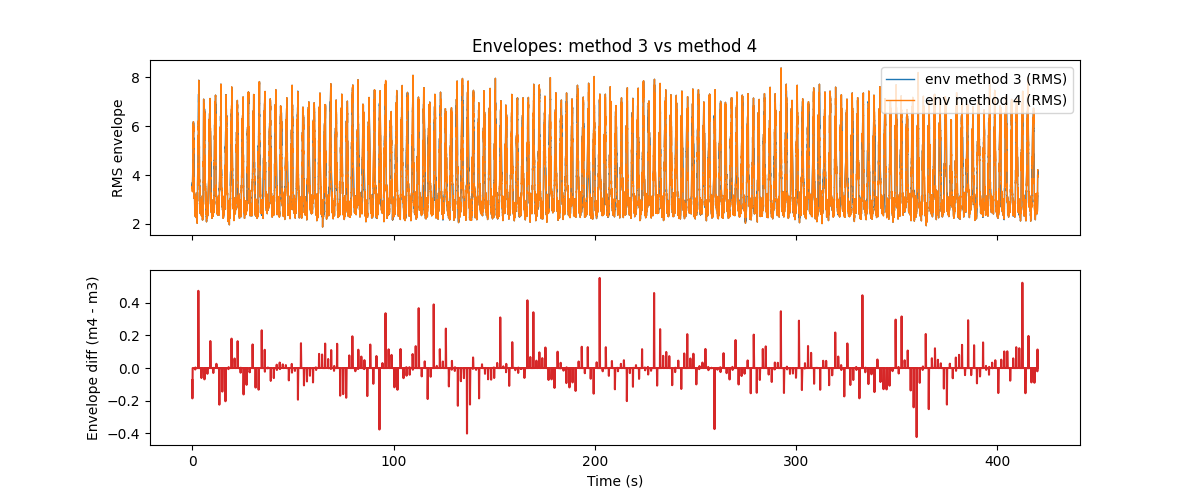

In [22]:
# Plot difference between cubic (method 4) and linear/rms (method 3)
out_m3 = gating_new(emg_raw=y_emg_filt[1, :], peak_idxs=ecg_peaks_idxs, method=3, gate_width=window)
out_m4 = gating_new(emg_raw=y_emg_filt[1, :], peak_idxs=ecg_peaks_idxs, method=4, gate_width=window)
diff_34 = out_m4 - out_m3
# compute RMS envelopes and show a quick comparison
env_m3 = evl.full_rolling_rms(out_m3, window)
env_m4 = evl.full_rolling_rms(out_m4, window)
diff_env = env_m4 - env_m3

fig_env, ax_env = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax_env[0].plot(t_emg, env_m3, label='env method 3 (RMS)', color='tab:blue', lw=1)
ax_env[0].plot(t_emg, env_m4, label='env method 4 (RMS)', color='tab:orange', lw=1)
ax_env[0].set_ylabel('RMS envelope')
ax_env[0].set_title('Envelopes: method 3 vs method 4')
ax_env[0].legend(loc='upper right')

ax_env[1].plot(t_emg, diff_env, color='tab:red')
ax_env[1].set_ylabel('Envelope diff (m4 - m3)')
ax_env[1].set_xlabel('Time (s)')
# plt.tight_layout()